## Survival analysis for Park et al. classes

For now, we'll just consider samples with a point mutation and CNV as "two-hit" samples, and samples with either but not both as "one-hit" samples. We could make this more granular in the future (i.e. use multiple point mutations as evidence of "two-hitness", or deep CNVs as "two-hit" samples as well).

In [1]:
from pathlib import Path
import pickle as pkl

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.compare import compare_survival
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.util import Surv

import sys; sys.path.append('..')
import config as cfg

In [2]:
MPMP_LOCATION = Path('/home/jake/research/mpmp')

# park et al. geneset info
park_loss_data = cfg.data_dir / 'park_loss_df.tsv'
park_gain_data = cfg.data_dir / 'park_gain_df.tsv'

# park et al. significant gene info
park_loss_sig_data = cfg.data_dir / 'park_loss_df_sig_only.tsv'
park_gain_sig_data = cfg.data_dir / 'park_gain_df_sig_only.tsv'

### Load information for Park et al. genes

In [3]:
park_loss_sig_df = pd.read_csv(park_loss_sig_data, sep='\t', index_col=0)
park_loss_sig_df.head()

,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification
AJUBA_HNSC,AJUBA,HNSC,-0.936050,8.732955e-03,0.045816,1.338886,A_Hit,TSG
ARID1A_LGG,ARID1A,LGG,-0.904202,1.956617e-02,0.076291,1.117471,A_Hit,TSG
ARID1A_STAD,ARID1A,STAD,1.133548,3.979932e-04,0.000294,3.517309,B_Target,TSG
ARID1A_UCEC,ARID1A,UCEC,1.597876,3.451937e-07,0.000000,5.000000,B_Target,TSG
ARID2_LIHC,ARID2,LIHC,-0.978419,1.019284e-02,0.050276,1.298552,A_Hit,TSG


In [4]:
park_gain_sig_df = pd.read_csv(park_gain_sig_data, sep='\t', index_col=0)
park_gain_sig_df.head()

,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification
ARID1A_UCEC,ARID1A,UCEC,-2.351526,1.154365e-03,-0.000447,3.340299,B_Target,TSG
ATRX_LGG,ATRX,LGG,1.440987,4.025141e-08,0.000000,5.000000,A_Hit,TSG
BRAF_SKCM,BRAF,SKCM,1.239939,2.042839e-11,0.000000,5.000000,A_Hit,Oncogene
BRAF_THCA,BRAF,THCA,-2.449684,7.509064e-04,-0.000209,3.659041,B_Target,Oncogene
CTNNB1_UCEC,CTNNB1,UCEC,-1.257861,1.597968e-02,0.096292,1.016366,B_Target,Oncogene


### Get clinical endpoint info

Code for preprocessing clinical info is based on: https://github.com/greenelab/mpmp/blob/master/mpmp/utilities/data_utilities.py#L510

TODO: move this to a function/utilities file

In [5]:
# use TCGA clinical data downloaded in mpmp repo
clinical_filename = (
    MPMP_LOCATION / 'data' / 'raw' / 'TCGA-CDR-SupplementalTableS1.xlsx'
)

In [6]:
clinical_df = pd.read_excel(
    clinical_filename,
    sheet_name='TCGA-CDR',
    index_col='bcr_patient_barcode',
    engine='openpyxl'
)

clinical_df.index.rename('patient_id', inplace=True)

# drop numeric index column
clinical_df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

# we want to use age as a covariate
clinical_df.rename(columns={'age_at_initial_pathologic_diagnosis': 'age'},
                   inplace=True)

print(clinical_df.shape)
clinical_df.iloc[:5, :5]

(11160, 32)


,type,age,gender,race,ajcc_pathologic_tumor_stage
patient_id,,,,,
TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II
TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV
TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III
TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV
TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III


In [7]:
# we want to use overall survival as the target variable except for
# certain cancer types where progression-free intervals are typically
# used (since very few deaths are observed)
# this is recommended in https://doi.org/10.1016/j.cell.2018.02.052
pfi_cancer_types = [
    'BRCA', 'DLBC', 'LGG', 'PCPG', 'PRAD',
    'READ', 'TGCT', 'THCA', 'THYM'
]

clinical_df['time_in_days'] = clinical_df['OS.time']
clinical_df['status'] = clinical_df['OS'].astype('bool')

pfi_samples = clinical_df.type.isin(pfi_cancer_types)
clinical_df.loc[pfi_samples, 'time_in_days'] = clinical_df[pfi_samples]['PFI.time']
clinical_df.loc[pfi_samples, 'status'] = clinical_df[pfi_samples]['PFI'].astype('bool')

# clean up columns and drop samples with NA survival times
na_survival_times = (clinical_df['time_in_days'].isna())
cols_to_keep = ['status', 'time_in_days', 'age', 'type']
clinical_df = clinical_df.loc[~na_survival_times, cols_to_keep].copy()

# mean impute missing age values
clinical_df.age.fillna(clinical_df.age.mean(), inplace=True)

print(clinical_df.shape)
clinical_df.head()

(11094, 4)


,status,time_in_days,age,type
patient_id,,,,
TCGA-OR-A5J1,True,1355.0,58.0,ACC
TCGA-OR-A5J2,True,1677.0,44.0,ACC
TCGA-OR-A5J3,False,2091.0,23.0,ACC
TCGA-OR-A5J4,True,423.0,23.0,ACC
TCGA-OR-A5J5,True,365.0,30.0,ACC


### Get mutated samples info

TODO: move this to a function/utilities file

In [8]:
# mutation and copy number data
pancancer_pickle = MPMP_LOCATION / 'data' / 'pancancer_data.pkl'

with open(pancancer_pickle, 'rb') as f:
    pancancer_data = pkl.load(f)

In [9]:
# get (binary) mutation data
# 1 = observed non-silent mutation in this gene for this sample, 0 otherwise
mutation_df = pancancer_data[1]
print(mutation_df.shape)
mutation_df.iloc[:5, :5]

(9074, 20938)


,5S_rRNA,A1BG,A1CF,A2M,A2ML1
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [10]:
# we use the data source and preprocessing code from the pancancer repo, here:
# https://github.com/greenelab/pancancer/blob/d1b3de7fa387d0a44d0a4468b0ac30918ed66886/scripts/initialize/process_copynumber.py#L21

copy_thresh_df = (
    pd.read_csv(cfg.data_dir / 'pancan_GISTIC_threshold.tsv',
                sep='\t', index_col=0)
      .drop(columns=['Locus ID', 'Cytoband'])
)
copy_thresh_df.columns = copy_thresh_df.columns.str[0:15]

# thresholded copy number includes 5 values [-2, -1, 0, 1, 2], which
# correspond to "deep loss", "moderate loss", "no change",
# "moderate gain", and "deep gain", respectively.
print(copy_thresh_df.shape)
copy_thresh_df.iloc[:5, :5]

(25128, 10713)


,TCGA-OR-A5J1-01,TCGA-OR-A5J2-01,TCGA-OR-A5J3-01,TCGA-OR-A5J4-01,TCGA-OR-A5J5-01
Gene Symbol,,,,,
ACAP3,0,0,0,1,0
ACTRT2,0,0,0,1,0
AGRN,0,0,0,1,0
ANKRD65,0,0,0,1,0
ATAD3A,0,0,0,1,0


In [11]:
sample_freeze_df = pancancer_data[0]
copy_samples = list(
    set(sample_freeze_df.SAMPLE_BARCODE)
    .intersection(set(copy_thresh_df.columns))
)
print(len(copy_samples))

9068


In [12]:
# make sure we're not losing too many samples, a few is fine
print(sorted(set(sample_freeze_df.SAMPLE_BARCODE) - set(copy_thresh_df.columns)))

['TCGA-06-0152-02', 'TCGA-06-0171-02', 'TCGA-06-0221-02', 'TCGA-14-0736-02', 'TCGA-ER-A19T-01', 'TCGA-ER-A2NF-01']


In [13]:
copy_thresh_df = (copy_thresh_df
    .T
    .loc[sorted(copy_samples)]
    .fillna(0)
    .astype(int)
)

print(copy_thresh_df.shape)
copy_thresh_df.iloc[:5, :5]

(9068, 25128)


Gene Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,1,1,1,1,1
TCGA-02-2483-01,-1,-1,-1,-1,-1
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [14]:
# here, we want to use "moderate" and "deep" loss/gain to define CNV
# loss/gain (to match Park et al.)
#
# note that this is different to the more conservative approach of using
# "deep loss/gain" only as in our classifiers

copy_loss_df = (copy_thresh_df
    .replace(to_replace=[1, 2], value=0)
    .replace(to_replace=[-1, -2], value=1)
)
print(copy_loss_df.shape)
copy_loss_df.iloc[:5, :5]

(9068, 25128)


Gene Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,1,1,1,1,1
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [15]:
copy_gain_df = (copy_thresh_df
    .replace(to_replace=[-1, -2], value=0)
    .replace(to_replace=[1, 2], value=1)
)
print(copy_gain_df.shape)
copy_gain_df.iloc[:5, :5]

(9068, 25128)


Gene Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,1,1,1,1,1
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


### Get sample info and groups for gene/cancer type

In [16]:
def get_groups_for_gene_and_tissue(identifier,
                                   cancer_classification,
                                   hits_classification):
    """Given a gene and tissue, load the relevant mutation/CNV information,
    and divide the samples into groups to compare survival.
    
    TODO document cancer_classification and hits_classification
    """
    # get patient ids (first 12 of TCGA identifier) with mutation info
    mut_patient_ids = mutation_df.index.str[:12]
    
    # get patient ids in given cancer type 
    gene, tissue = identifier.split('_')
    tissue_ids = (clinical_df
        .query('type == @tissue')
        .index
        # mutation_df and the CNV dfs have the same index, so we
        # only have to check this one rather than all of them
        .intersection(mut_patient_ids)
    )
    id_clinical_df = clinical_df.loc[tissue_ids, :].copy()
    
    # get mutation and copy status
    mutation_status = mutation_df.loc[
        mutation_df.index.str[:12].isin(mut_patient_ids), gene
    ]
    if cancer_classification == 'TSG':
        copy_status = copy_loss_df.loc[
            copy_loss_df.index.str[:12].isin(mut_patient_ids), gene
        ]
    elif cancer_classification == 'Oncogene':
        copy_status = copy_gain_df.loc[
            copy_gain_df.index.str[:12].isin(mut_patient_ids), gene
        ]
        
    mutation_status.index = mutation_status.index.str[:12]
    copy_status.index = copy_status.index.str[:12]
        
    # get groups from mutation/CNV data
    if hits_classification == 'one':
        id_clinical_df['is_mutated'] = (mutation_status | copy_status).astype(int)
        id_clinical_df['is_mutated_alt'] = (mutation_status & copy_status).astype(int)
    elif hits_classification == 'two':
        id_clinical_df['is_mutated'] = (mutation_status & copy_status).astype(int)
        id_clinical_df['is_mutated_alt'] = (mutation_status | copy_status).astype(int)
        
    return id_clinical_df

In [17]:
# test for a selected example
identifier = 'RB1_BLCA'
cancer_classification = 'TSG'
hits_classification = 'two'

id_clinical_df = get_groups_for_gene_and_tissue(
    identifier, cancer_classification, hits_classification)

print(id_clinical_df.shape)
print(id_clinical_df.is_mutated.sum(), id_clinical_df.is_mutated_alt.sum())
print(id_clinical_df.isna().sum()) 
id_clinical_df.head()

(397, 6)
48 179
status            0
time_in_days      0
age               0
type              0
is_mutated        0
is_mutated_alt    0
dtype: int64


,status,time_in_days,age,type,is_mutated,is_mutated_alt
TCGA-2F-A9KO,True,734.0,63.0,BLCA,0,0
TCGA-2F-A9KP,True,364.0,66.0,BLCA,0,0
TCGA-2F-A9KQ,False,2886.0,69.0,BLCA,0,0
TCGA-2F-A9KR,True,3183.0,59.0,BLCA,0,0
TCGA-2F-A9KT,False,3314.0,83.0,BLCA,0,0


is_mutated chisq = 0.1613 p = 6.8799e-01
is_mutated_alt chisq = 0.4374 p = 5.0840e-01


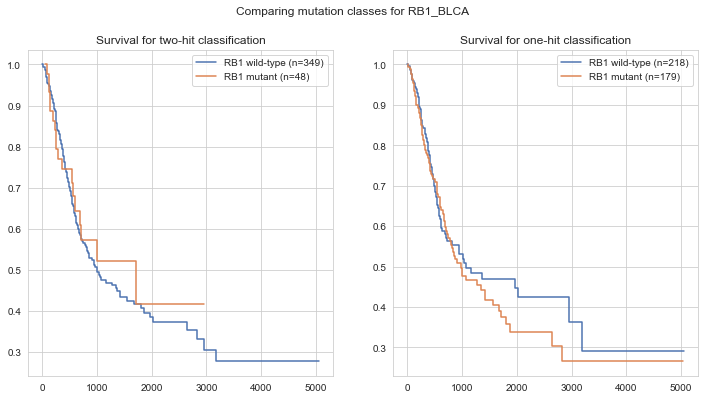

In [18]:
# plot groups
sns.set({'figure.figsize': (12, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)

def plot_id(identifier, id_clinical_df):
    
    gene, tissue = identifier.split('_')

    for ix, mut_col in enumerate(['is_mutated', 'is_mutated_alt']):

        ax = axarr[ix]

        n_mutant = id_clinical_df[mut_col].sum()
        n_wildtype = id_clinical_df.shape[0] - n_mutant

        for is_mutated in id_clinical_df[mut_col].unique():
            mask_mutated = (id_clinical_df[mut_col] == is_mutated)
            time_treatment, survival_prob_treatment = kaplan_meier_estimator(
                id_clinical_df['status'][mask_mutated],
                id_clinical_df['time_in_days'][mask_mutated]
            )

            def get_label(gene, is_mutated, n_mutant, n_wildtype):
                if is_mutated:
                    return '{} mutant (n={})'.format(gene, n_mutant)
                else:
                    return '{} wild-type (n={})'.format(gene, n_wildtype)

            # TODO: confidence intervals
            ax.step(time_treatment, survival_prob_treatment, where="post",
                    label=get_label(gene, is_mutated, n_mutant, n_wildtype))

        ax.legend()

        def get_n_hits(hits_class, ix):
            hits_desc = (['one', 'two'] if hits_class == 'one' else ['two', 'one'])
            return hits_desc[ix]

        ax.set_title('Survival for {}-hit classification'.format(
            get_n_hits(hits_classification, ix)))

        # hypothesis testing using log-rank test
        y = Surv.from_dataframe('status', 'time_in_days', id_clinical_df)
        chisq, p_val = compare_survival(y, id_clinical_df[mut_col].values)
        print(mut_col, 'chisq = {:.4f}'.format(chisq), 'p = {:.4e}'.format(p_val))

    plt.suptitle('Comparing mutation classes for {}'.format(identifier))
    
plot_id(identifier, id_clinical_df)

### Run for all "class 2" genes

We'll just start here for now, these are all tumor suppressors that Park et al. have annotated as "two-hit loss" drivers (i.e. classical tumor suppressors).

We want to see how many of them (if any) distinguish between survival groups more effectively for two-hit samples as opposed to one-hit samples (TODO: be a bit clearer with what we're doing here).

In [19]:
class_2_ids = park_loss_sig_df.index.unique()
print(len(class_2_ids))
print(class_2_ids[:10])

79
Index(['AJUBA_HNSC', 'ARID1A_LGG', 'ARID1A_STAD', 'ARID1A_UCEC', 'ARID2_LIHC',
       'BAP1_KIRP', 'BAP1_LIHC', 'BCOR_UCEC', 'BRD7_LIHC', 'CDH1_BRCA'],
      dtype='object')


We want to build a dataframe with:
* identifier
* \# WT samples
* \# mutant samples
* survival p-value
* \# WT samples (alt classification)
* \# mutant samples (alt classification)
* survival p-value (alt classification)

In [20]:
class_2_surv_df = []
columns = [
    'identifier',
    'n_mutant',
    'n_wildtype',
    'chisq',
    'p_val',
    'n_mutant_alt',
    'n_wildtype_alt',
    'chisq_alt',
    'p_val_alt',
]

for identifier in class_2_ids:
    
    results = [identifier]
    
    id_clinical_df = get_groups_for_gene_and_tissue(
        identifier, 'TSG', 'two')
    
    for ix, mut_col in enumerate(['is_mutated', 'is_mutated_alt']):
    
        n_mutant = id_clinical_df[mut_col].sum()
        n_wildtype = id_clinical_df.shape[0] - n_mutant
        
        if n_mutant == 0 or n_wildtype == 0:
            print(identifier, mut_col, n_mutant, n_wildtype, file=sys.stderr)
            continue
    
        # hypothesis testing using log-rank test
        try:
            y = Surv.from_dataframe('status', 'time_in_days', id_clinical_df)
        except ValueError:
            # this happens for COADREAD, TODO fix it later
            print(identifier, file=sys.stderr)
            continue
        chisq, p_val = compare_survival(y, id_clinical_df[mut_col].values)
        results += [n_mutant, n_wildtype, chisq, p_val]
        
    if len(results) == len(columns):
        class_2_surv_df.append(results)
        
class_2_surv_df = pd.DataFrame(
    class_2_surv_df,
    columns=columns
)
class_2_surv_df.set_index('identifier')

class_2_surv_df['ts_diff'] = class_2_surv_df.chisq - class_2_surv_df.chisq_alt
class_2_surv_df['p_val_diff'] = class_2_surv_df.p_val - class_2_surv_df.p_val_alt

print(class_2_surv_df.shape)
class_2_surv_df.sort_values(by='ts_diff', ascending=False).head(20)

TP53_COADREAD
TP53_COADREAD


(78, 11)


,identifier,n_mutant,n_wildtype,chisq,p_val,n_mutant_alt,n_wildtype_alt,chisq_alt,p_val_alt,ts_diff,p_val_diff
15,CUL3_KIRP,3,267,18.623700,1.592287e-05,18,252,0.069411,7.921960e-01,18.554289,-7.921801e-01
62,TP53_LAML,4,103,19.450035,1.032659e-05,17,90,3.425565,6.419427e-02,16.024470,-6.418395e-02
71,TP53_THYM,2,116,19.529491,9.905851e-06,17,101,3.703357,5.430312e-02,15.826135,-5.429322e-02
55,SMARCA4_LUAD,30,463,6.482451,1.089446e-02,274,219,0.532422,4.655905e-01,5.950030,-4.546961e-01
34,NSD1_HNSC,34,453,4.262560,3.896117e-02,211,276,0.288571,5.911378e-01,3.973989,-5.521767e-01
47,PTPDC1_LAML,1,106,3.136637,7.655149e-02,6,101,0.016791,8.968973e-01,3.119846,-8.203458e-01
29,NF1_LGG,6,499,27.288500,1.752506e-07,47,458,24.441636,7.659533e-07,2.846864,-5.907027e-07
21,HRAS_BLCA,4,393,2.524029,1.121238e-01,220,177,0.450897,5.019094e-01,2.073132,-3.897856e-01
72,TP53_UCEC,105,401,20.395459,6.297907e-06,206,300,18.614631,1.599879e-05,1.780827,-9.700888e-06
39,PTEN_BRCA,35,945,3.366081,6.655190e-02,326,654,1.734231,1.878714e-01,1.631849,-1.213195e-01


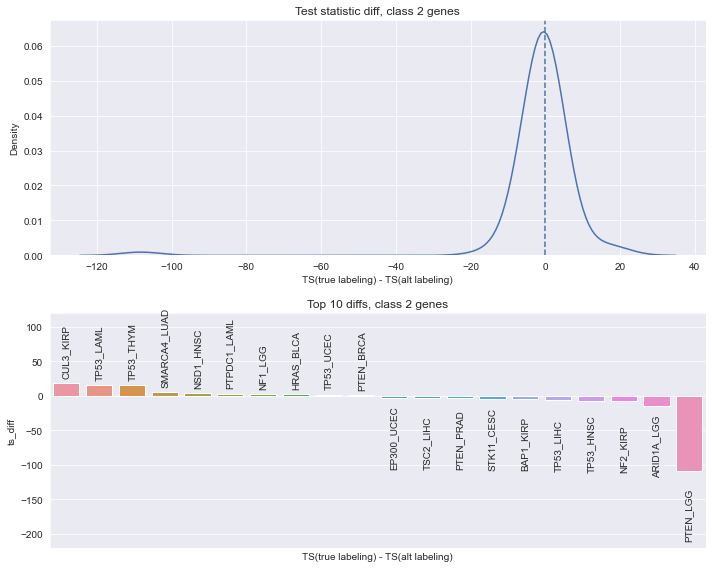

In [21]:
sns.set({'figure.figsize': (10, 8)})
fig, axarr = plt.subplots(2, 1)

sns.kdeplot(data=class_2_surv_df.ts_diff, ax=axarr[0])
axarr[0].axvline(0, linestyle='--')
axarr[0].set_title('Test statistic diff, class 2 genes')
axarr[0].set_xlabel('TS(true labeling) - TS(alt labeling)')

metric = 'ts'
num_examples = 10

top_df = (class_2_surv_df
    .sort_values(by='{}_diff'.format(metric), ascending=False)
    .head(num_examples)
)
bottom_df = (class_2_surv_df
    .sort_values(by='{}_diff'.format(metric), ascending=False)
    .tail(num_examples)
)
plot_df = pd.concat((top_df, bottom_df)).reset_index()
sns.barplot(data=plot_df, x=plot_df.index, y='{}_diff'.format(metric),
            dodge=False, ax=axarr[1])
axarr[1].set_xticks([])
axarr[1].set_title('Top 10 diffs, class 2 genes')
axarr[1].set_xlabel('TS(true labeling) - TS(alt labeling)')

def show_values_on_bars(ax):
    for i in range(plot_df.shape[0]):
        _x = i
        _y = plot_df.loc[i, '{}_diff'.format(metric)]
        val = plot_df.loc[i, 'identifier']
        if _y > 0:
            ax.text(_x, _y + 10, val, ha="center", rotation=90) 
        else:
            ax.text(_x, _y - 100, val, ha="center", rotation=90)
            
axarr[1].set_ylim(-220, 120)
show_values_on_bars(axarr[1])

plt.tight_layout()

is_mutated chisq = 1.4476 p = 2.2891e-01
is_mutated_alt chisq = 9.1374 p = 2.5044e-03


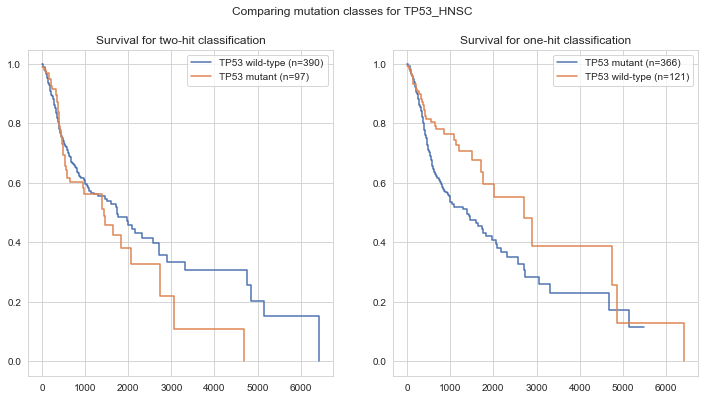

In [25]:
sns.set({'figure.figsize': (12, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)

identifier = 'TP53_HNSC'

id_clinical_df = get_groups_for_gene_and_tissue(
    identifier, 'TSG', 'two')

plot_id(identifier, id_clinical_df)